# Predicting Sentiment in Tweets Involving the Dallas Mavericks

#### Brian Johns, May 2023

Analyzing sentiment on social media can be a helpful tool for Professional Sports organizations.  It is one way that a teram can understand how their fans are feeling about the team, and could perhaps get further insight about which players on the team are more (or less) popular.

For this project, I am using a season's worth of tweets that contained the key phrase 'Dallas Mavericks' from September 30, 2021 to June 1, 2022.  This captures the entire 2021-22 season for the Dallas Mavericks, where they placed 4th in the Western Conference on their way to being a Western Conference Finalist.

Using this data, I hope to answer the following business question:

**How can we predict the sentiment of tweets directed at a professional sports team** (in this case, the Dallas Mavericks)?

Being able to predict sentiment of tweets can help a professional sports team in a variety of ways such as:
- Targeting users/tweets that are highly positive for future advertisements and promotions
- Targeting users/tweets that are highly negative to disengage from future involvement with the team
- Evaluating the effectiveness of team promotions and campaigns by seeing the fans response and engagement

These tweets were collected by Alex Huggler and were downloaded from Kaggle on June 14, 2022 from Kaggle at the following link.: https://www.kaggle.com/datasets/alexhuggler/dallas-mavericks-twitter-data-for-20212022-games

For this project, there are four notebooks.

1. Data Cleaning & EDA
2. Feature Engineering & NLP 
3. Predicting Sentiment Using Classification Models
4. Final Summary & Analysis

# Notebook #1: Data Cleaning & Initial EDA

In this notebook, I will show the following:

1. [Load Data](#loading)
2. [Initial Exploratory Data Analysis](#initialeda)
3. [Data Cleaning](#cleaning)
4. [Sentiment Scoring](#sentimentscore)
5. [Secondary Exploratory Data Analysis with Cleaned Tweets](#secondaryeda)
6. [Export Cleaned Data](#export)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geonamescache

import unidecode

import regex as re

import pickle

import datetime

<a id = 'loading'></a>

## 1. Loading Data

In [2]:
mavs_df = pd.read_csv('Mavericks.csv', index_col = 0)

In [3]:
mavs_df.head()

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,language,Twitter Access Point,Follower Count,Friends Count,verified
0,2022-06-01 23:54:00+00:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,Virginia,1,0,0,en,Twitter for Android,4073,3248,False
1,2022-06-01 23:53:27+00:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,"Grand Prairie, TX",0,0,8,en,Twitter for iPhone,341,219,False
2,2022-06-01 23:51:11+00:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,Virginia,0,0,0,en,Twitter for Android,4073,3248,False
3,2022-06-01 23:50:42+00:00,1532147657153695744,Hey @mcuban do the city of Dallas a favor sign...,DKylesBoi,"Dallas, Texas",0,0,0,en,Twitter for iPhone,1348,154,True
4,2022-06-01 23:44:12+00:00,1532146022679465984,@lynchscott41 @jcjp17 @dallasmavsshop @dallasm...,JebusBlonde,The Republic of Texas,0,0,0,en,Twitter for iPhone,58,308,False


In [4]:
mavs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343007 entries, 0 to 343006
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Datetime              343007 non-null  object
 1   Tweet Id              343007 non-null  int64 
 2   Text                  343007 non-null  object
 3   Username              343007 non-null  object
 4   location              218196 non-null  object
 5   reply count           343007 non-null  int64 
 6   retweet count         343007 non-null  int64 
 7   like count            343007 non-null  int64 
 8   language              343007 non-null  object
 9   Twitter Access Point  343007 non-null  object
 10  Follower Count        343007 non-null  int64 
 11   Friends Count        343007 non-null  int64 
 12  verified              343007 non-null  bool  
dtypes: bool(1), int64(6), object(6)
memory usage: 34.3+ MB


In [5]:
# Datetime is an object initially, changing to Datetime data
mavs_df['Datetime'] = pd.to_datetime(mavs_df['Datetime']).dt.tz_convert('US/Central')

In [6]:
mavs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343007 entries, 0 to 343006
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype                     
---  ------                --------------   -----                     
 0   Datetime              343007 non-null  datetime64[ns, US/Central]
 1   Tweet Id              343007 non-null  int64                     
 2   Text                  343007 non-null  object                    
 3   Username              343007 non-null  object                    
 4   location              218196 non-null  object                    
 5   reply count           343007 non-null  int64                     
 6   retweet count         343007 non-null  int64                     
 7   like count            343007 non-null  int64                     
 8   language              343007 non-null  object                    
 9   Twitter Access Point  343007 non-null  object                    
 10  Follower Count        343007 non

There are 343,007 tweets that used the 'Dallas Mavericks' key phrase during this time frame.

An initial look would make it appear that the data is fairly complete, with the exception of the `location` for the tweet, where there are over 120K+ null values.

<a id = 'initialeda'></a>

## 2. Initial Exploratory Data Analysis

After some quick cleaning we have the following features for this data.

**Numeric:**  `reply count`, `retweet count`, `like count`, `Datetime`, `Follower Count`, `Friends Count`

**Categorical:**  `location`, `language`, `Twitter Access Point`, `verified`.  `username` is the username that sent each tweet and could be treated as categorical as well.

**Text Data:**  `text` that will end up being the corpus of our NLP project

**ID:** `Tweet id` for the individualized tag for each tweet.

At the start, we have 343007 rows of data across 13 columns.  Let's see what each of these features looks like, starting with the numeric data, saving the `Datetime` column for further analysis later.

Only 1 column currently has null values, `location`.  To enable analysis for this column, I will fill these null values with 'Unknown' until an appropriate way to fill these values becomes apparent.

### Note on Languages

It is my hope to return to this project at a later date in order to translate the non-english texts.  Attempts to use Google Translate (googletrans) proved unreliable for a dataset this size.

For now, I will drop all non-english language tweets as well as the language column as it will no longer have any differentiating features.

In [7]:
mavs_en = mavs_df[mavs_df['language'] == 'en'].reset_index(drop = True).drop(columns = 'language')

In [8]:
mavs_en['location'] = mavs_en['location'].fillna('Unknown')

All of the numeric columns are integers, so I will select the columns with that data type and get a sense of their distribution in the dataset.

In [9]:
mavs_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262916 entries, 0 to 262915
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype                     
---  ------                --------------   -----                     
 0   Datetime              262916 non-null  datetime64[ns, US/Central]
 1   Tweet Id              262916 non-null  int64                     
 2   Text                  262916 non-null  object                    
 3   Username              262916 non-null  object                    
 4   location              262916 non-null  object                    
 5   reply count           262916 non-null  int64                     
 6   retweet count         262916 non-null  int64                     
 7   like count            262916 non-null  int64                     
 8   Twitter Access Point  262916 non-null  object                    
 9   Follower Count        262916 non-null  int64                     
 10   Friends Count        262916 non

We now have 262,916 tweets, all in english, with no null values in any of the 12 columns for the time being.

In [10]:
numeric_mavs_df = mavs_en.select_dtypes('int64').drop(columns = 'Tweet Id')

In [11]:
numeric_mavs_df.columns

Index(['reply count', 'retweet count', 'like count', 'Follower Count',
       ' Friends Count'],
      dtype='object')

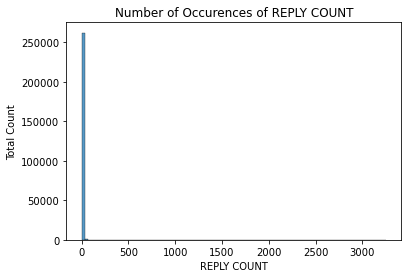

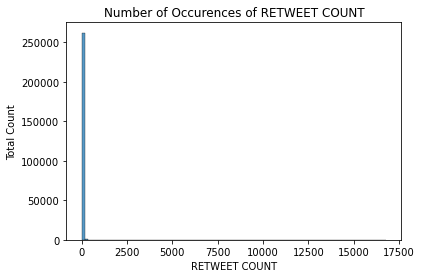

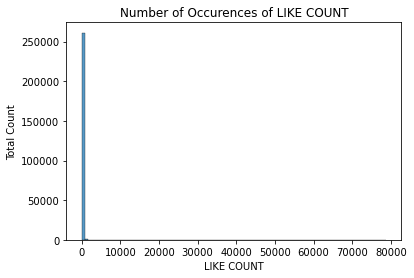

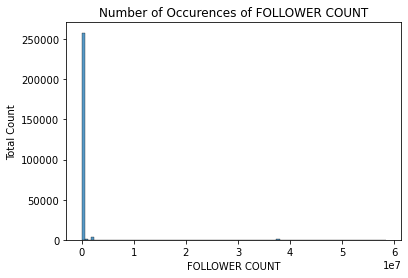

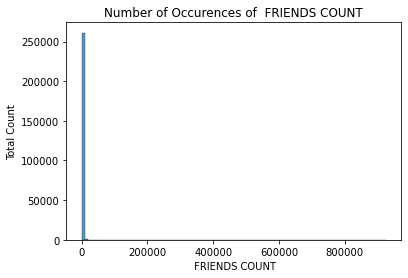

In [12]:
# Histogram of each column in the data
for col in numeric_mavs_df.columns:
    plt.figure()
    sns.histplot(x = numeric_mavs_df[col], data = numeric_mavs_df, bins = 100)
    plt.title('Number of Occurences of '+col.upper())
    plt.xlabel(col.upper())
    plt.ylabel('Total Count')
    plt.show()

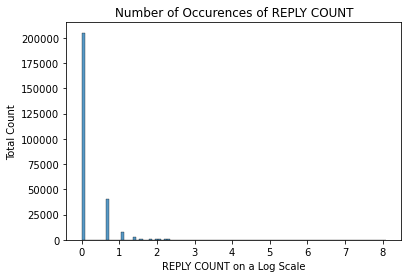

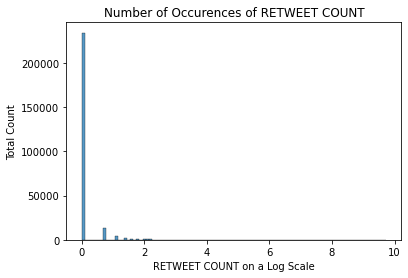

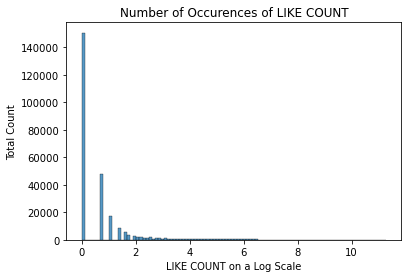

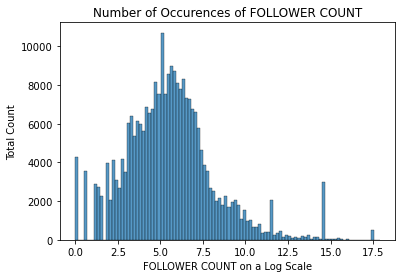

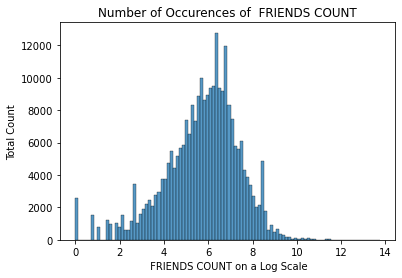

In [13]:
# Data is HEAVILY skewed, re-doing histograms on the Log of each column to better understand their distributions
for col in numeric_mavs_df.columns:
    plt.figure()
    sns.histplot(x = np.log(numeric_mavs_df[col]+1), data = numeric_mavs_df, bins = 100)
    plt.title('Number of Occurences of '+col.upper())
    plt.xlabel(col.upper()+' on a Log Scale')
    plt.ylabel('Total Count')
    plt.show()

Even on a log scale, `like count`, `retweet count` and `reply count` still have heavily exponential distributions.  There are A LOT of tweets that do not get any engagement along these factors.  Perhaps these can be better shown as distributions as with/without in these categories.

`Friends Count` and `Followers Count` on the other hand have closer to normal distributions once they have been put on a log scale, with `Followers Count` showing a slight right skew, whereas `Friends Count` is more symmetrically normal.

In [14]:
# Just taking the like, retweet and reply columns
counts_df = pd.DataFrame(columns = ['Like', 'Retweet', 'Reply'])

In [15]:
# Creating binary columns of tweets with and without these interactions
counts_df['Like'] = np.where(mavs_en['like count'] > 0, 'Yes', 'No')
counts_df['Retweet'] = np.where(mavs_en['retweet count'] > 0, 'Yes', 'No')
counts_df['Reply'] = np.where(mavs_en['reply count'] > 0, 'Yes', 'No')

In [16]:
counts_df['Like'].value_counts(normalize = True)

No     0.573061
Yes    0.426939
Name: Like, dtype: float64

In [17]:
counts_df['Retweet'].value_counts(normalize = True)

No     0.889748
Yes    0.110252
Name: Retweet, dtype: float64

In [18]:
counts_df['Reply'].value_counts(normalize = True)

No     0.780192
Yes    0.219808
Name: Reply, dtype: float64

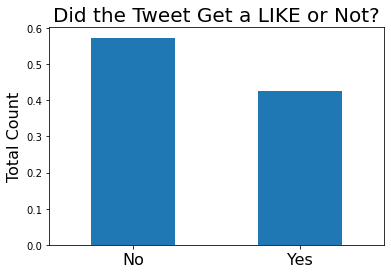

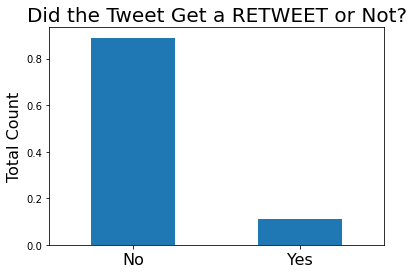

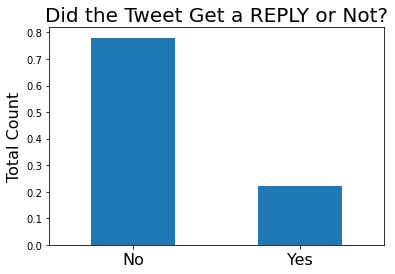

In [19]:
for col in counts_df.columns:
    counts_df[col].value_counts(normalize = True).plot(kind = 'bar', )
    plt.title('Did the Tweet Get a '+col.upper()+' or Not?', fontsize = 20)
    plt.xticks(rotation = 0, fontsize = 16)
    plt.ylabel('Total Count', fontsize = 16)
    plt.show()

Seeing if tweets had ANY engagement at all, the totals are still heavily skewed towards NO on each of these factors.  `like count` has the most balanced distribution, with 57.3% of all messages earning a like.  `reply count` is much lower at 22.0% getting a reply, and `retweet count` lower still at 11.0%.

Next we will look at the categorical variables.

In [20]:
# The text column will be saved for future analysis
categorical_mavs_df = mavs_en.select_dtypes(['object']).drop(columns = 'Text')

In [21]:
categorical_mavs_df.head()

,Username,location,Twitter Access Point
0,RL26VA,Virginia,Twitter for Android
1,YWLAArnoldGirls,"Grand Prairie, TX",Twitter for iPhone
2,RL26VA,Virginia,Twitter for Android
3,DKylesBoi,"Dallas, Texas",Twitter for iPhone
4,JebusBlonde,The Republic of Texas,Twitter for iPhone


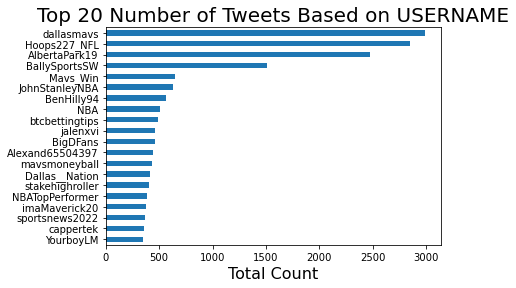

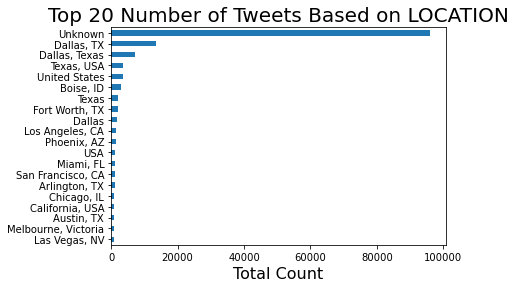

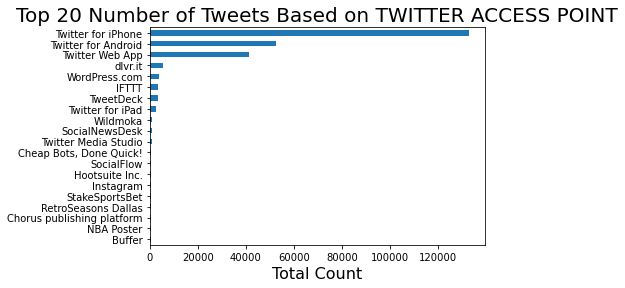

In [22]:
# There are a lot of Usernames and Locations, so I will look at just the top 20 of each column
for col in categorical_mavs_df.columns:
    df = categorical_mavs_df[col].value_counts().head(20).sort_values(ascending = True) #Top 20 for each column
    df.plot(kind = 'barh')
    plt.title('Top 20 Number of Tweets Based on '+col.upper(), fontsize = 20)
    plt.xlabel('Total Count', fontsize = 16)
    plt.show()

In [23]:
mavs_en['Twitter Access Point'].str.contains('Twitter').value_counts(normalize = True)

True     0.878836
False    0.121164
Name: Twitter Access Point, dtype: float64

There are a few trends to see in the categorical columns.

For `Twitter Access Point`, 87.9% of the tweets come from the Twitter app through a variety of sources, most commonly an iPhone.  `dlvr.it` is an automated social media posting service and is the most common access point for tweets that were not posted through Twitter directly.

After the 'Unknown' locations, it is unsurprisingly that the most common `location` for all of the Dallas Mavericks tweets was the city of Dallas.  However, in addition to the 'Unknown' locations, even just seeing the top 20 results here outlines that there will need to be some cleaning required for this column as the top two entries were 'Dallas, TX' and 'Dallas, Texas'.  Other common locations include 'Texas', 'Texas, USA' and 'United States'. 

The user with the most tweets is the offical username of the Dallas Mavericks team.  After that, there is a mix of Dallas Mavericks fan sites (Mavs_Win, mavsmoneyball), auto-posters (Hoops227_NFL, AlbertaParks19) and gambling sites (BallySportsSW, stakehighroller).

Some considerations that could be used for Sentiment Analysis:

1. Filter High Volume users.  Many of these users are not posting anything specific about the Mavericks, but just relaying game times, betting lines or other generic information.
2. Filter Official sources.  While news-worthy, getting tweets directly the Dallas Mavericks, NBA, or other notable news sources (such as Shams Charania or Adrian Wojnarowski) may not give a true sense of what is coming from the fans either.  Perhaps only un-verified accounts could be considered, or some filtering of verified accounts.

Next I'll look specifically at the `verified` account distribution.

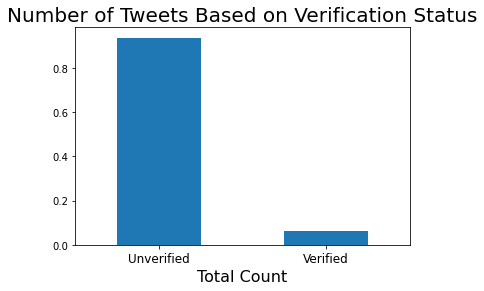

In [24]:
mavs_en['verified'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('Number of Tweets Based on Verification Status', fontsize = 20)
plt.xlabel('Total Count', fontsize = 16)
plt.xticks(rotation = 0, ticks = [0, 1], labels = ['Unverified', 'Verified'], fontsize = 12)
plt.show()

In [25]:
mavs_en['verified'].value_counts(normalize = True)

False    0.93625
True     0.06375
Name: verified, dtype: float64

The vast majority, over 93%, of the tweets come from unverified accounts.  It is possible that this could be an effective to filter out 'actual' fans of the Dallas Mavericks (vs official news sources/other teams/media personaalities) but a closer look at the users for both verified and unverified accounts may give better insight.

In [26]:
verified_df = mavs_en[mavs_en['verified'] == True]
unverified_df = mavs_en[mavs_en['verified'] == False]

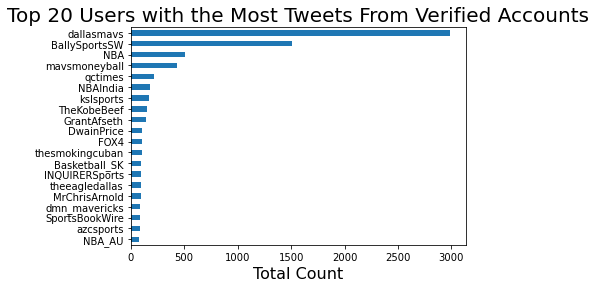

In [27]:
verified_df['Username'].value_counts().head(20).sort_values(ascending = True).plot(kind = 'barh')
plt.title('Top 20 Users with the Most Tweets From Verified Accounts', fontsize = 20)
plt.xlabel('Total Count', fontsize = 16)
plt.show()

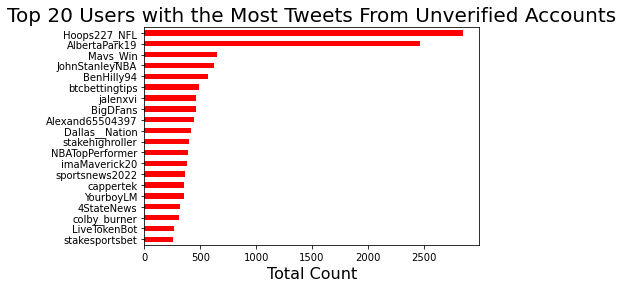

In [28]:
unverified_df['Username'].value_counts().head(20).sort_values(ascending = True).plot(kind = 'barh', color = 'red')
plt.title('Top 20 Users with the Most Tweets From Unverified Accounts', fontsize = 20)
plt.xlabel('Total Count', fontsize = 16)
plt.show()

A large portion of the verified accounts that had the most tweets about the Dallas Mavericks were the NBA and the official NBA feed in different locations (ie. NBAIndia).  There are also some prominent Mavericks specific blogs (mavsmoneyball, TheKobeBeef, thesmokingcuban) in addition to traditional media outlets (FOX4, qctimes, kslsports).

For the unverified users, there is a lot of users who are auto-posters where the information is generic (Hoops227_NFL, AlbertaPark19, NBATopPerformer) or gambling specific (btcbettingtips, stakehighroller).  However, there are some high volume unverified accounts from 'real' people (Mavs_Win, colby_burner) that produce a steady stream of tweets that are geared more specifically to either the Mavericks, or for sports teams in Dallas generally.

<a id = 'cleaning'></a>

## 3. Initial Data Cleaning:

### `Location`

In [29]:
mavs_en['location'].value_counts()

Unknown                       96001
Dallas, TX                    13562
Dallas, Texas                  7214
Texas, USA                     3575
United States                  3494
                              ...  
Silverton, OR                     1
610                               1
Golden State                      1
The 9 IE 🖖🏾🙏🏾                     1
THE GREAT STATE OF TEXAS 🌠        1
Name: location, Length: 22841, dtype: int64

There is a significant amount of cleaning to do to the `location` as there are different spellings for many locations.  In addition, a very significant portion of the data also has an unknown location.  Seeing this, my goal will be to make 5 categories for location in order to make it more specific to the analysis for the Dallas Mavericks:

1. Dallas
2. Texas (But not Dallas)
3. USA (But not Texas)
4. International (but not USA)
5. Unknown

Once these categories have been made, perhaps more specific insights could be made about the location of the tweets provided.  

For this project, I will look at the insights of these general locations.  It is possible that individual countries (rather than grouping as international) or individual States (rather than combing them all into the 'United States') could be analyzed further, but this will not be the purpose of this project.

We are starting the cleaning with 22,841 different values for location, let's try to clean this up.

First focusing on Dallas.

In [30]:
dallas_df = mavs_en[mavs_en['location'].str.contains('dallas')]

In [31]:
dallas_df['location'].value_counts()

dallas                            45
dallas, tx                        34
dallas tx                         22
20 dallas he/him                  12
dallas/boston he/his               6
dallas texas boiiii!!              5
east dallas                        5
Instagram: dallasmavsdotnet        4
dallas texas                       4
dallas                             4
los angeles, ca via dallas, tx     4
dallas • okc, ok • houston         3
dallas , tx                        3
dallas, texas                      3
dallaska                           2
dallas,tx                          2
Honestly idk lbk or dallas         2
south dallas baby                  1
dallas babayy                      1
dirtydirtydallas                   1
Afdallastan Flexas                 1
dallas,texas                       1
dallas, tx, y'all                  1
baltimore ♡ dc ♡ dallas            1
dallas, TX                         1
dallas TX                          1
baton rouge ➡️ dallas              1
d

Seeing that we have a variety of upper/lower casings for the location, it's clear that I will have to put everything into the same case in hopes of combining many of these locations.

In [32]:
mavs_df2 = mavs_en.copy()

In [33]:
mavs_df2.head()

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Twitter Access Point,Follower Count,Friends Count,verified
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,Virginia,1,0,0,Twitter for Android,4073,3248,False
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,"Grand Prairie, TX",0,0,8,Twitter for iPhone,341,219,False
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,Virginia,0,0,0,Twitter for Android,4073,3248,False
3,2022-06-01 18:50:42-05:00,1532147657153695744,Hey @mcuban do the city of Dallas a favor sign...,DKylesBoi,"Dallas, Texas",0,0,0,Twitter for iPhone,1348,154,True
4,2022-06-01 18:44:12-05:00,1532146022679465984,@lynchscott41 @jcjp17 @dallasmavsshop @dallasm...,JebusBlonde,The Republic of Texas,0,0,0,Twitter for iPhone,58,308,False


In [34]:
# Make everything upper case
mavs_df2['location'] = mavs_df2['location'].apply(lambda x: x.upper())
# Removing all accents
mavs_df2['location'] = mavs_df2['location'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [35]:
mavs_df2['location'].value_counts()

UNKNOWN                      96006
DALLAS, TX                   13828
DALLAS, TEXAS                 7227
UNITED STATES                 3672
TEXAS, USA                    3588
                             ...  
BEYOND THE HORIZON               1
DALLAS  TEXAS                    1
FACTORY OF SADNESS               1
NORTH VERNON, IN                 1
THE GREAT STATE OF TEXAS         1
Name: location, Length: 20964, dtype: int64

In [36]:
# Simple changes first, first for Dallas
mavs_df2.loc[mavs_df2['location'].str.contains('DALLAS'), 'location'] = 'DALLAS'

In [37]:
# Second for Texas
mavs_df2.loc[mavs_df2['location'].str.contains('TX'), 'location'] = 'TEXAS'
mavs_df2.loc[mavs_df2['location'].str.contains('TEXAS'), 'location'] = 'TEXAS'

In [38]:
mavs_df2['location'].value_counts()

UNKNOWN                           96006
DALLAS                            27627
TEXAS                             24935
UNITED STATES                      3672
BOISE, ID                          2967
                                  ...  
KD'S HEAD                             1
COOPERATIVA, SAO BERNARDO DO C        1
NOT HEAVEN                            1
SUPERDOME, NEW ORLEANS                1
IN CHRIST.                            1
Name: location, Length: 19010, dtype: int64

Already starting to collapse the categories here, as that cleaning has removed around 4000 differing values.

In previous iterations, it was appearent that some may use the area code of their phone number as part of their input for their location.  Dallas has 214, 972 and 469 area codes, let's see if this is the case.

In [39]:
areacodes = ['214', '469', '972']
mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(areacodes)), 'location'].value_counts()

UT: -6.909423,107.694972         56
214                              41
THE 972  THE 4TH CITY  GP        10
214/972                           7
THE 214.                          6
DIRTY D 214                       2
31.707616,-106.192144             2
TEJAS 214/361/512/817             2
THA VILLE 97214                   2
972                               2
3245'N, 9720'W                    2
UT: -6.2214436,106.8315427        2
337-214                           1
214 TO 469 TO 972                 1
214713                            1
214, DUH.                         1
ATLANTA, GA BY WAY OF THE 214     1
SC:SENOR2VASOS IG:ITSSOLO214      1
254 TO 214                        1
214-216                           1
UT: 38.59469,-121.440245          1
214 & 333                         1
901/214                           1
Name: location, dtype: int64

This does not seem to be as cut and dry, as many do look like area codes, but the numbers could also be a part of a coordinate that is not the same place.  In fact, the top result of the value count appears to be coordinates in Indonesia.

It does appear that *most* of those that used an area code in their location did it in isolation (simply '214') or on its own within the sentence (DIRTY D *214*).  Perhaps we can isolate these examples by singling out locations that had only 3 characters in them with the area code, along with others that had white space before or after the area code.

I believe matching strings with startswith and endswith will take care of most of these accurately.

In [40]:
mavs_df2.loc[mavs_df2['location'].str.startswith('214'), 'location'] = 'DALLAS'
mavs_df2.loc[mavs_df2['location'].str.endswith('214'), 'location'] = 'DALLAS'
mavs_df2.loc[mavs_df2['location'].str.startswith('972'), 'location'] = 'DALLAS'

In [41]:
mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(areacodes)), 'location'].value_counts()

UT: -6.909423,107.694972      56
THE 972  THE 4TH CITY  GP     10
THE 214.                       6
UT: -6.2214436,106.8315427     2
3245'N, 9720'W                 2
TEJAS 214/361/512/817          2
31.707616,-106.192144          2
UT: 38.59469,-121.440245       1
Name: location, dtype: int64

In [42]:
# A few more have a white space in front of 214 and 972
mavs_df2.loc[mavs_df2['location'].str.contains(' 214'), 'location'] = 'DALLAS'
mavs_df2.loc[mavs_df2['location'].str.contains(' 972'), 'location'] = 'DALLAS'

In [43]:
mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(areacodes)), 'location'].value_counts()

UT: -6.909423,107.694972      56
UT: -6.2214436,106.8315427     2
31.707616,-106.192144          2
UT: 38.59469,-121.440245       1
Name: location, dtype: int64

From here, we only have locations that have coordinates left.  We will leave these alone for the time being as we may be able to use some tools to identify remaining locations that are coordinates or group them with one of the categories.

In [44]:
mavs_df2['location'].value_counts()

UNKNOWN            96006
DALLAS             27711
TEXAS              24935
UNITED STATES       3672
BOISE, ID           2967
                   ...  
TOMORROWLAND           1
PLANET VEGATA          1
BATMAN, TURKIYE        1
KD'S HEAD              1
IN CHRIST.             1
Name: location, Length: 18991, dtype: int64

Next, I will use a dictionary of State abbreviations in order to identify and classify these tweets as coming from 'United States'

In [45]:
# Dictionary of states
states = {
    'AK': 'ALASKA',
    'AL': 'ALABAMA',
    'AR': 'ARKANSAS',
    'AZ': 'ARIZONA',
    'CA': 'CALIFORNIA',
    'CO': 'COLORADO',
    'CT': 'CONNECTICUT',
    'DC': 'DISTRICT OF COLUMBIA',
    'DE': 'DELAWARE',
    'FL': 'FLORIDA',
    'GA': 'GEORGIA',
    'HI': 'HAWAII',
    'IA': 'IOWA',
    'ID': 'IDAHO',
    'IL': 'ILLINOIS',
    'IN': 'INDIANA',
    'KS': 'KANSAS',
    'KY': 'KENTUCKY',
    'LA': 'LOUISIANA',
    'MA': 'MASSACHUSETTS',
    'MD': 'MARYLAND',
    'ME': 'MAINE',
    'MI': 'MICHIGAN',
    'MN': 'MINNESOTA',
    'MO': 'MISSOURI',
    'MS': 'MISSISSIPPI',
    'MT': 'MONTANA',
    'NC': 'NORTH CAROLINA',
    'ND': 'NORTH DAKOTA',
    'NE': 'NEBRASKA',
    'NH': 'NEW HAMPSHIRE',
    'NJ': 'NEW JERSEY',
    'NM': 'NEW MEXICO',
    'NV': 'NEVADA',
    'NY': 'NEW YORK',
    'OH': 'OHIO',
    'OK': 'OKLAHOMA',
    'OR': 'OREGON',
    'PA': 'PENNSYLVANIA',
    'RI': 'RHODE ISLAND',
    'SC': 'SOUTH CAROLINA',
    'SD': 'SOUTH DAKOTA',
    'TN': 'TENNESSEE',
    'US': 'UNITED STATES',#Adding US in this dictionary
    #'TX': 'TEXAS', excluding Texas
    'UT': 'UTAH',
    'VA': 'VIRGINIA',
    'VT': 'VERMONT',
    'WA': 'WASHINGTON',
    'WI': 'WISCONSIN',
    'WV': 'WEST VIRGINIA',
    'WY': 'WYOMING'
}

In [46]:
spacestatekeys = [f' {key}' for key in states]
cleanstatekeys = [f'{key}' for key in states]
statevalues = list(states.values())

In [47]:
mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(statevalues)), 'location'] = 'UNITED STATES'

In [48]:
for n in range(0, mavs_df2.shape[0]):
    if mavs_df2['location'][n].strip()[-3:] in spacestatekeys \
    or mavs_df2['location'][n].strip() in cleanstatekeys \
    or mavs_df2['location'][n].strip()[-4:] == ' USA' \
    or mavs_df2['location'][n].strip() == 'USA':
    #or mavs_df2['location'][n].strip() == 'US':
        mavs_df2['location'][n] = 'UNITED STATES'

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1469377725.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_df2['location'][n] = 'UNITED STATES'


In [49]:
mavs_df2['location'].value_counts()

UNKNOWN            96006
UNITED STATES      52150
DALLAS             27711
TEXAS              24935
                    1395
                   ...  
HUNTING WINNERS        1
CICERO,IL              1
R.I.P. KOBE            1
OUTTA NOWHERE          1
IN CHRIST.             1
Name: location, Length: 13861, dtype: int64

This significantly brought the total number of `location` values, removing nearly 5000 different values and classifying them as coming from the 'United States', making it the largest known `location` of tweets at this point.

Now, I will do the same for counties and classify them as 'International' tweets.

### Countries

In [50]:
countries = {"AF":"Afghanistan",
"AX":"Aland Islands",
"AL":"Albania",
"DZ":"Algeria",
"AS":"American Samoa",
"AD":"Andorra",
"AO":"Angola",
"AI":"Anguilla",
"AQ":"Antarctica",
"AG":"Antigua and Barbuda",
"AR":"Argentina",
"AM":"Armenia",
"AW":"Aruba",
"AU":"Australia",
"AT":"Austria",
"AZ":"Azerbaijan",
"BS":"Bahamas",
"BH":"Bahrain",
"BD":"Bangladesh",
"BB":"Barbados",
"BY":"Belarus",
"BE":"Belgium",
"BZ":"Belize",
"BJ":"Benin",
"BM":"Bermuda",
"BT":"Bhutan",
"BO":"Bolivia, Plurinational State of",
"BQ":"Bonaire, Sint Eustatius and Saba",
"BA":"Bosnia and Herzegovina",
"BW":"Botswana",
"BV":"Bouvet Island",
"BR":"Brazil",
"BX":"Brasil", #Adding common alternate spelling
"IO":"British Indian Ocean Territory",
"BN":"Brunei Darussalam",
"BG":"Bulgaria",
"BF":"Burkina Faso",
"BI":"Burundi",
"KH":"Cambodia",
"CM":"Cameroon",
"CA":"Canada",
"CV":"Cape Verde",
"KY":"Cayman Islands",
"CF":"Central African Republic",
"TD":"Chad",
"CL":"Chile",
"CN":"China",
"CX":"Christmas Island",
"CC":"Cocos (Keeling) Islands",
"CO":"Colombia",
"KM":"Comoros",
"CG":"Congo",
"CD":"Congo, The Democratic Republic of the",
"CK":"Cook Islands",
"CR":"Costa Rica",
"CI":"Côte d'Ivoire",
"HR":"Croatia",
"CU":"Cuba",
"CW":"Curaçao",
"CY":"Cyprus",
"CZ":"Czech Republic",
"DK":"Denmark",
"DJ":"Djibouti",
"DM":"Dominica",
"DO":"Dominican Republic",
"EC":"Ecuador",
"EG":"Egypt",
"SV":"El Salvador",
"GQ":"Equatorial Guinea",
"ER":"Eritrea",
"EE":"Estonia",
"ET":"Ethiopia",
"FK":"Falkland Islands (Malvinas)",
"FO":"Faroe Islands",
"FJ":"Fiji",
"FI":"Finland",
"FR":"France",
"GF":"French Guiana",
"PF":"French Polynesia",
"TF":"French Southern Territories",
"GA":"Gabon",
"GM":"Gambia",
"GE":"Georgia",
"DE":"Germany",
"DX":"Deutschland", #alternate name
"GH":"Ghana",
"GI":"Gibraltar",
"GR":"Greece",
"GL":"Greenland",
"GD":"Grenada",
"GP":"Guadeloupe",
"GU":"Guam",
"GT":"Guatemala",
"GG":"Guernsey",
"GN":"Guinea",
"GW":"Guinea-Bissau",
"GY":"Guyana",
"HT":"Haiti",
"HM":"Heard Island and McDonald Islands",
"VA":"Holy See (Vatican City State)",
"HN":"Honduras",
"HK":"Hong Kong",
"HU":"Hungary",
"IS":"Iceland",
"IN":"India",
"ID":"Indonesia",
"IR":"Iran, Islamic Republic of",
"IQ":"Iraq",
"IE":"Ireland",
"IM":"Isle of Man",
"IL":"Israel",
"IT":"Italy",
"IX":"Italia", #Alternate Spelling
"JM":"Jamaica",
"JP":"Japan",
"JE":"Jersey",
"JO":"Jordan",
"KZ":"Kazakhstan",
"KE":"Kenya",
"KI":"Kiribati",
"KP":"Korea, Democratic People's Republic of",
"KR":"Korea, Republic of",
"KW":"Kuwait",
"KG":"Kyrgyzstan",
"LA":"Lao People's Democratic Republic",
"LV":"Latvia",
"LB":"Lebanon",
"LS":"Lesotho",
"LR":"Liberia",
"LY":"Libya",
"LI":"Liechtenstein",
"LT":"Lithuania",
"LU":"Luxembourg",
"MO":"Macao",
"MK":"Macedonia, Republic of",
"MG":"Madagascar",
"MW":"Malawi",
"MY":"Malaysia",
"MV":"Maldives",
"ML":"Mali",
"MT":"Malta",
"MH":"Marshall Islands",
"MQ":"Martinique",
"MR":"Mauritania",
"MU":"Mauritius",
"YT":"Mayotte",
"MX":"Mexico",
"FM":"Micronesia, Federated States of",
"MD":"Moldova, Republic of",
"MC":"Monaco",
"MN":"Mongolia",
"ME":"Montenegro",
"MS":"Montserrat",
"MA":"Morocco",
"MZ":"Mozambique",
"MM":"Myanmar",
"NA":"Namibia",
"NR":"Nauru",
"NP":"Nepal",
"NL":"Netherlands",
"NC":"New Caledonia",
"NZ":"New Zealand",
"NI":"Nicaragua",
"NE":"Niger",
"NG":"Nigeria",
"NU":"Niue",
"NF":"Norfolk Island",
"MP":"Northern Mariana Islands",
"NO":"Norway",
"OM":"Oman",
"PK":"Pakistan",
"PW":"Palau",
"PS":"Palestinian Territory, Occupied",
"PA":"Panama",
"PG":"Papua New Guinea",
"PY":"Paraguay",
"PE":"Peru",
"PH":"Philippines",
"PN":"Pitcairn",
"PL":"Poland",
"PT":"Portugal",
"PR":"Puerto Rico",
"QA":"Qatar",
"RE":"Réunion",
"RO":"Romania",
"RU":"Russian Federation",
"RW":"Rwanda",
"BL":"Saint Barthélemy",
"SH":"Saint Helena, Ascension and Tristan da Cunha",
"KN":"Saint Kitts and Nevis",
"LC":"Saint Lucia",
"MF":"Saint Martin (French part)",
"PM":"Saint Pierre and Miquelon",
"VC":"Saint Vincent and the Grenadines",
"WS":"Samoa",
"SM":"San Marino",
"ST":"Sao Tome and Principe",
"SA":"Saudi Arabia",
"SN":"Senegal",
"RS":"Serbia",
"SC":"Seychelles",
"SL":"Sierra Leone",
"SG":"Singapore",
"SX":"Sint Maarten (Dutch part)",
"SK":"Slovakia",
"SI":"Slovenia",
"SV":"Slovenija", #Alternate spelling, Luka Doncic's home country
"SB":"Solomon Islands",
"SO":"Somalia",
"ZA":"South Africa",
"GS":"South Georgia and the South Sandwich Islands",
"ES":"Spain",
"EX":"Espana", #Adding common alternate name
"LK":"Sri Lanka",
"SD":"Sudan",
"SR":"Suriname",
"SS":"South Sudan",
"SJ":"Svalbard and Jan Mayen",
"SZ":"Swaziland",
"SE":"Sweden",
"CH":"Switzerland",
"SY":"Syrian Arab Republic",
"TW":"Taiwan, Province of China",
"TJ":"Tajikistan",
"TZ":"Tanzania, United Republic of",
"TH":"Thailand",
"TL":"Timor-Leste",
"TG":"Togo",
"TK":"Tokelau",
"TO":"Tonga",
"TT":"Trinidad and Tobago",
"TN":"Tunisia",
"TR":"Turkey",
"TM":"Turkmenistan",
"TC":"Turks and Caicos Islands",
"TV":"Tuvalu",
"UG":"Uganda",
"UA":"Ukraine",
"AE":"United Arab Emirates",
"GB":"United Kingdom",
"UK":"United Kingdom",
#"US":"United States",
"UM":"United States Minor Outlying Islands",
"UY":"Uruguay",
"UZ":"Uzbekistan",
"VU":"Vanuatu",
"VE":"Venezuela, Bolivarian Republic of",
"VN":"Viet Nam",
"VG":"Virgin Islands, British",
"VI":"Virgin Islands, U.S.",
"WF":"Wallis and Futuna",
"YE":"Yemen",
"ZM":"Zambia",
"ZW":"Zimbabwe"}

In [51]:
spacecountrykeys = [f' {key}' for key in countries]
cleancountrykeys = [f'{key}' for key in countries]
countryvalues = list(map(lambda x: x.upper(), countries.values()))

In [52]:
mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(countryvalues)), 'location'] = 'INTERNATIONAL'

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1155938772.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(countryvalues)), 'location'] = 'INTERNATIONAL'


In [53]:
for n in range(0, mavs_df2.shape[0]):
    if mavs_df2['location'][n].strip()[-3:] in spacecountrykeys \
    or mavs_df2['location'][n].strip() in cleancountrykeys:
        mavs_df2['location'][n] = 'INTERNATIONAL'

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/518022353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_df2['location'][n] = 'INTERNATIONAL'


Similar to tweets coming from different states, there are many tweets that only have a province or state listed from different countries.  I will identify the most common of these and label them as 'International'.

First, Canadian provinces.

In [54]:
province2 = {"AB":"Alberta",
"BC":"British Columbia",
"SK":"Saskatchewan",
"MB":"Manitoba",
"ON":"Ontario",
"QC":"Quebec",
"NB":"New Brunswick",
"NS":"Nova Scotia",
"PE":"Prince Edward Island",
"NL":"Newfoundland",
"YK":"Yukon",
"NT":"Northwest Territories",
"NU":"Nunavut",
"SA":"South Australia",
"WA":"Western Australia"}

In [55]:
province3 = {"NSW":"New South Wales",
"QLD":"Queensland",
"TAS":"Tasmania",
#"VIC":"Victoria", Victoria is a city in Texas, disincluded for now
"ACT":"Australian Capital Territory"
    }

In [56]:
spaceprovince2keys = [f' {key}' for key in province2]
cleanprovince2keys = [f'{key}' for key in province2]
province2values = list(map(lambda x: x.upper(), province2.values()))

In [57]:
spaceprovince3keys = [f' {key}' for key in province3]
cleanprovince3keys = [f'{key}' for key in province3]
province3values = list(map(lambda x: x.upper(), province3.values()))

In [58]:
mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(province2values)), 'location'] = 'INTERNATIONAL'
mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(province3values)), 'location'] = 'INTERNATIONAL'

In [59]:
for n in range(0, mavs_df2.shape[0]):
    if mavs_df2['location'][n].strip()[-3:] in spaceprovince2keys \
    or mavs_df2['location'][n].strip() in cleanprovince2keys \
    or mavs_df2['location'][n].strip()[-4:] in spaceprovince3keys \
    or mavs_df2['location'][n].strip() in cleanprovince3keys:
        mavs_df2['location'][n] = 'INTERNATIONAL'

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/995118154.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_df2['location'][n] = 'INTERNATIONAL'


Now to cast the net a bit wider.  I am going to use the GeoNames library, which a list of all cities, with different signifiers (such as provinces and countries) that will help identify cities.

Here, I will use this library in order to parse out tweets that have a `location` that is only the name of the city that they're from.  I will identify those that are in Texas first, making the assumption that in this dataset that it is more likely that someone using just a city name, that may be duplicated somewhere else, is more likely to be in Texas than any other location.

I am making the same assumption with tweets from the United States, assuming that tweets are from there before International ones (particularly as I filtered out only English language tweets).

In [60]:
# Instantiating the library
gc = geonamescache.GeonamesCache()

In [61]:
# Instantiating the cities dictionary
citymapper = gc.get_cities()

In [62]:
# Turning the keys in the dictionary into a list of city names
citykeys = [key for key in citymapper]

In [63]:
# Making different lists for each location based on the listed assumptions
intlnames = []
usnames = []
texasnames = []
for n in range(len(citykeys)):
    value = citykeys[n]
    if (citymapper[value]['countrycode'] == 'US') & (citymapper[value]['admin1code'] == 'TX'):
        texasnames.append(citymapper[value]['name'].upper())
    elif citymapper[value]['countrycode'] == 'US':
        usnames.append(citymapper[value]['name'].upper())
    else:
        intlnames.append(citymapper[value]['name'].upper())

In [64]:
# Removing Dallas as a city in these lists so that tweets from Dallas stay listed as such
usnames.remove('DALLAS')
texasnames.remove('DALLAS')

In [65]:
mavs_df2.loc[mavs_df2['location'].str.contains('|'.join(texasnames)), 'location'] = 'TEXAS'

In [66]:
def clean_cities(cities):
    citylist = list(dict.fromkeys(cities))
    for city in citylist:
        unidecode.unidecode(city)

In [67]:
clean_cities(usnames)

In [68]:
clean_cities(intlnames)

In [69]:
mavs_df2.loc[(mavs_df2['location'].str.contains('|'.join(usnames))) \
                     & (mavs_df2['location'] != 'INTERNATIONAL'), 'location'] = 'UNITED STATES'

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1338255069.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mavs_df2.loc[(mavs_df2['location'].str.contains('|'.join(usnames))) \


In [70]:
mavs_df2.loc[(mavs_df2['location'].str.contains('|'.join(intlnames))) \
             & (mavs_df2['location'] != 'UNITED STATES') \
             & (mavs_df2['location'] != 'UNKNOWN'), 'location'] = 'INTERNATIONAL'

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/557557677.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mavs_df2.loc[(mavs_df2['location'].str.contains('|'.join(intlnames))) \


In [71]:
mavs_df2['location'].value_counts()

UNKNOWN             96006
UNITED STATES       58312
INTERNATIONAL       31157
DALLAS              27711
TEXAS               26754
                    ...  
LOLMETS                 1
956  512  210           1
TWITCH.TV/DAVVON        1
WHERE AM I              1
IN CHRIST.              1
Name: location, Length: 5434, dtype: int64

After starting with 22000+ locations, I have now categorized most of them and the vast majority are in the 5 categories I have set out to make.

With this, I would like to see common locations that have not fit into these categories, and see if there are additional tactics I can take to accurately classify them.

In [72]:
mavs_df2['location'][(mavs_df2['location'] != 'UNITED STATES') & 
        (mavs_df2['location'] != 'TEXAS') &
       (mavs_df2['location'] != 'UNKNOWN') &
       (mavs_df2['location'] != 'DALLAS') &
       (mavs_df2['location'] != 'INTERNATIONAL')].value_counts()

                                  1395
DFW                                567
EVERYWHERE                         548
WORLDWIDE                          407
EARTH                              404
                                  ... 
NORDIC VALLEY                        1
COMING SOON                          1
MI/BKN GGS, YZ/RY BB, KAT GBVS       1
CHI                                  1
IN CHRIST.                           1
Name: location, Length: 5429, dtype: int64

I'll try to get the low hanging fruit by hard coding the most common locations for tweets that haven't been classified yet.  There a few iterations of discovery, I will start with what we have below.

In [73]:
mavs_df2.loc[mavs_df2['location'] == 'DFW', 'location'] = 'DALLAS'
mavs_df2.loc[mavs_df2['location'].str.contains('NYC'), 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'WINDYCITYCHINWBURBS', 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'DMV', 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'EUROPE', 'location'] = 'INTERNATIONAL'
mavs_df2.loc[mavs_df2['location'] == 'SUGONDESE', 'location'] = 'INTERNATIONAL'
mavs_df2.loc[mavs_df2['location'] == 'PHILLY', 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'SOCAL', 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'LA', 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'TEJAS', 'location'] = 'TEXAS'
mavs_df2.loc[mavs_df2['location'] == 'US', 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'D', 'location'] = 'DALLAS'
mavs_df2.loc[mavs_df2['location'] == 'PACIFIC NORTHWEST', 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'THE LONE STAR STATE', 'location'] = 'TEXAS'
mavs_df2.loc[mavs_df2['location'].str.contains('POLSKA'), 'location'] = 'INTERNATIONAL'
mavs_df2.loc[mavs_df2['location'] == 'IZMIR', 'location'] = 'INTERNATIONAL'
mavs_df2.loc[mavs_df2['location'] == 'PACIFIC NORTHWEST', 'location'] = 'UNITED STATES'
mavs_df2.loc[mavs_df2['location'] == 'BIG D', 'location'] = 'DALLAS'

In [74]:
mavs_df2['location'][(mavs_df2['location'] != 'UNITED STATES') & 
        (mavs_df2['location'] != 'TEXAS') &
       (mavs_df2['location'] != 'UNKNOWN') &
       (mavs_df2['location'] != 'DALLAS') &
       (mavs_df2['location'] != 'INTERNATIONAL')].value_counts().sum()/mavs_df2.shape[0]

0.0807672412481553

Approximately 8% of the remaining tweets are not in one of the categories.  I will see again if there are anything glaring in at least the top 100 most common locations and see if there's more to do.

In [75]:
remainder_df = mavs_df2[(mavs_df2['location'] != 'UNITED STATES') & 
        (mavs_df2['location'] != 'TEXAS') &
       (mavs_df2['location'] != 'UNKNOWN') &
       (mavs_df2['location'] != 'DALLAS') &
       (mavs_df2['location'] != 'INTERNATIONAL')]

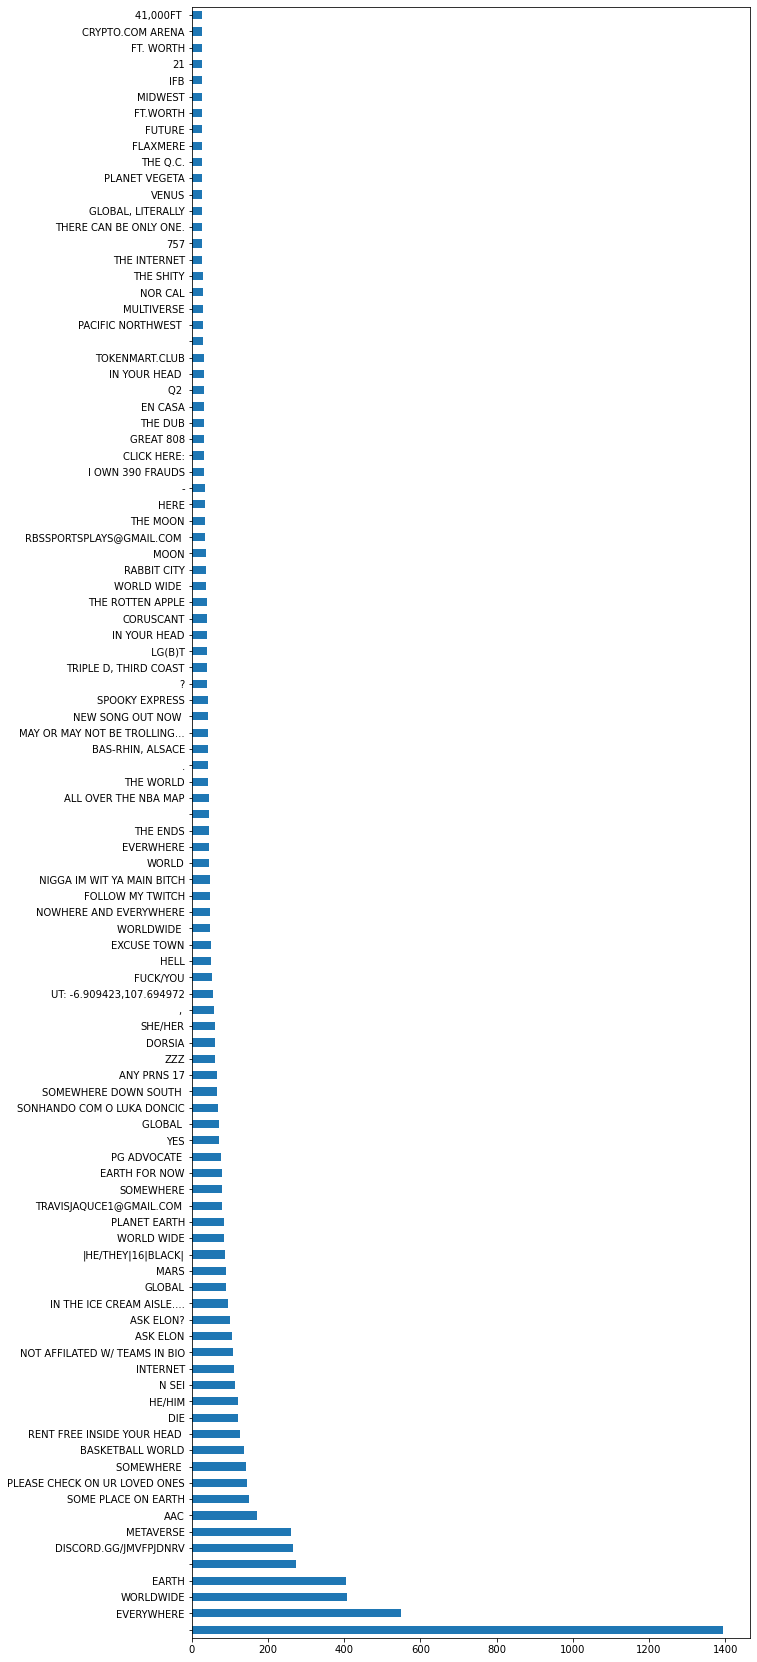

In [76]:
plt.figure(figsize = (10, 30))
remainder_df['location'].value_counts().head(100).plot(kind = 'barh')
plt.show()

A lot of these are vague or unhelpful.  Therefore, all of the remaining `locations` will be classified as unknown.

In [77]:
mavs_df2.loc[(mavs_df2['location'] != 'UNITED STATES') & 
        (mavs_df2['location'] != 'TEXAS') &
       (mavs_df2['location'] != 'UNKNOWN') &
       (mavs_df2['location'] != 'DALLAS') &
       (mavs_df2['location'] != 'INTERNATIONAL'), 'location'] = 'UNKNOWN'

In [78]:
mavs_df2['location'].value_counts()

UNKNOWN          117241
UNITED STATES     59132
INTERNATIONAL     31375
DALLAS            28344
TEXAS             26824
Name: location, dtype: int64

<a id = 'sentimentscore'></a>

## 4. Sentiment Scoring

In order to do an appropriate Sentiment Analysis on the english language tweets, a score is needed in order to best classify the tweets.  I will use **VADER** for this today.  I chose Vader because it does seem to capture the negative sentiment of statements more accurately.  More information and analysis on Vader vs Textblob can be found [HERE](https://www.analyticsvidhya.com/blog/2021/01/sentiment-analysis-vader-or-textblob/).  Considering that this is twitter data, I want to be sure that I want to capture negative sentiment as accurately as possible.

VADER returns four items, the first 3 being a negative score, neutral score and positive score, which add up to a total of 1.0.  These could be considered percentages of each category (50% neg, 25% neut, 25% pos = 100% total).  The fourth score is 'compound' which is an aggregate score of the three categories.  If the compound score is less than zero, then it is considered a negative statement.  If the compound score is greater than zero, it is considered a positive statement.  If the score is exactly 0, then it would be a perfectly neutral statement.

I will keep all of this data for the time being and conduct further EDA on the distributions.  However, what will be of most interest in regards to classifying the data will be the compound score.  Eventually, the compound score will be used to give the target variable, `Sentiment` for each of our tweets.

In [79]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [80]:
sid_obj = SentimentIntensityAnalyzer()

In [81]:
mavs_sentiment_df = mavs_df2.copy()

In [82]:
mavs_sentiment_df.head(3)

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Twitter Access Point,Follower Count,Friends Count,verified
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,UNITED STATES,1,0,0,Twitter for Android,4073,3248,False
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,TEXAS,0,0,8,Twitter for iPhone,341,219,False
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,UNITED STATES,0,0,0,Twitter for Android,4073,3248,False


In previous iterations, it was clear that the `Text` of each tweet required further cleaning, specifically removing links as well as '\n' strings representing where new lines were made within a tweet.

This cleaning, as well as adding new columns for sentiment scores, can be done with a single function where the text will be cleaned first, and then the cleaned text will be used to attain sentiment scores.

In [83]:
def score_sentiment(df):
    # Removing \n strings
    df['Text'] = df['Text'].str.replace('\n', '')
    
    # Adding scoring columns to the dataframe
    df['Positive'] = 0
    df['Neutral'] = 0
    df['Negative'] = 0
    df['Compound'] = 0
    
    # Sentiment will be the target variable
    df['Sentiment'] = 'N/A'
    
    for n in range(0, df.shape[0]):
        # Removing links from each tweet
        text = df['Text'][n]
        text = re.sub(r"http\S+", "", text)
        df['Text'][n] = text
        
        # Getting sentiment scores for each tweet and placing them into the dataframe
        scores = sid_obj.polarity_scores(text)
        
        df['Positive'][n] = scores['pos']
        df['Neutral'][n] = scores['neu']
        df['Negative'][n] = scores['neg']
        df['Compound'][n] = scores['compound']
        
        # Classify the tweet as Positive, Negative or Neutral based on the compound score
        if scores['compound'] > 0:
            df['Sentiment'][n] = 'Positive'
        elif scores['compound'] < 0:
            df['Sentiment'][n] = 'Negative'
        else:
            df['Sentiment'][n] = 'Neutral'
            
    return df

In [84]:
mavs_sentiment_df = score_sentiment(mavs_sentiment_df)

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1474832447.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'][n] = text
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1474832447.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Positive'][n] = scores['pos']
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1474832447.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [85]:
mavs_sentiment_df.head(3)

,Datetime,Tweet Id,Text,Username,location,reply count,retweet count,like count,Twitter Access Point,Follower Count,Friends Count,verified,Positive,Neutral,Negative,Compound,Sentiment
0,2022-06-01 18:54:00-05:00,1532148490922606594,Dallas Mavericks Send Insane Tweet ‘To Honor’ ...,RL26VA,UNITED STATES,1,0,0,Twitter for Android,4073,3248,False,0.000,0.722,0.278,-0.6124,Negative
1,2022-06-01 18:53:27-05:00,1532148352283992065,Thanks Dallas Mavericks for celebrating our #Y...,YWLAArnoldGirls,TEXAS,0,0,8,Twitter for iPhone,341,219,False,0.443,0.557,0.000,0.9722,Positive
2,2022-06-01 18:51:11-05:00,1532147780663316485,Dallas Mavericks Get Ripped To Shreds For ‘Hon...,RL26VA,UNITED STATES,0,0,0,Twitter for Android,4073,3248,False,0.000,0.909,0.091,-0.3182,Negative


It looks like we have successfully given some additional information for our data using Vader.  First I want to see some examples of some of the `Text` of some of the top scores for each category.

In [86]:
mavs_sentiment_df.sort_values('Positive', ascending = False).reset_index().head(10)['Text']

0                               Agreed. 
1                              SPECIAL. 
2                       Yeah, buddy 👌👌👌 
3                            YESSIR 👌👌👌 
4                       REGGIEEEEEEE 👌👌👌
5                             SPENCE 👌👌👌
6                              Deep 👌👌👌 
7                         REGGIEEEEE 👌👌👌
8                       Okay, DAVISSSS👌👌
9    @dallasmavs great win great defense
Name: Text, dtype: object

This seems to be OK generally, but it seems the 'OK' hand symbol emoji may be overweighting positive sentiments.  Let's see Negative scores.

In [87]:
mavs_sentiment_df.sort_values('Negative', ascending = False).reset_index().head(10)['Text']

0       DALLAS MAVERICKS BASKETBALL 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
1                          Dallas Mavericks 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
2                          Dallas Mavericks 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
3                                 @dallasmavs FIRE 🔥🔥🔥
4    El OVER TIME entre @dallasmavs 🆚 @Lakers 🔥🔥🔥🔥🔥...
5               LETS GOOOO!!!! @dallasmavs 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
6            63-44 LETS GO @dallasmavs 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
7                          @dallasmavs Suck Suck Suck!
8                             Dallas Mavericks🔥🔥🔥🔥🔥🔥🔥 
9                            @dallasmavs WTF!?!?!? Smh
Name: Text, dtype: object

This is a much bigger issue.  It seems that the Fire emoji has a heavy negative weight, and many of these messages use them multiple times.  But in the context of sport, being 'on fire' should be more of a positive connotation (just ask anyone who has played [NBA JAM](https://www.youtube.com/watch?v=X7dFMbubxr4)).

It is already clear that emoji's will have to be dealt with, but let's look at the scores for neutral and compound first.

In [88]:
mavs_sentiment_df.sort_values('Neutral', ascending = False).reset_index().head(10)['Text']

0                    Final in OT. @dallasmavs | #MFFL 
1    Hanging with the @dallasmavs this morning on @...
2    @TrolledByCeedee @dallasmavs @MichelobULTRA La...
3    NBA Picks Today: Phoenix Suns vs Dallas Maveri...
4    Looking for #betting advice on tonight's #NBAP...
5    @KDTrey5 Would bring up Draymond with 35 but t...
6    Game Of The Day: Dallas Mavericks vs. Houston ...
7      @charctrumann @dallasmavs @MichelobULTRA nobody
8    NBA, Playoffs 2nd Round, West Game #3:PHOENIX ...
9      Our boy up and running @dallasmavs @luka7doncic
Name: Text, dtype: object

For tweets that are suppose to be 100% neutral, this seems pretty good.  Many of the tweets are informational (generic game/betting information) but with no actual sentiment to it.

In [89]:
mavs_sentiment_df.sort_values('Compound', ascending = False).reset_index().head(10)['Text']

0    @getnickwright 😆😂😆😂😆😂😆😂😆😂😆😂😆😂😆😂😆😂😆😆😂😂😂😆😂😆😂😆😂😆😆...
1    @dallasmavs @Chime Let’s all laugh at Dallas M...
2    @getnickwright Dallas Mavericks 😆😆😆😂😂😆😂😂😂😂😂😆😆😂...
3    ITS GAME 4 OF THE #WESTERN #CONFERENCE #FINALS...
4    Is @stephenasmith still talking?@FirstTake The...
5    @PatrickMahomes @dallasmavs @luka7doncic Too b...
6    @PatrickMahomes @dallasmavs That  is so great ...
7    @dallasmavs @Chime 👀👌👀👌👀 good win go౦ԁ wIn👌 th...
8    @dallasmavs @Chime 5️⃣0️⃣ 👀👌👀👌👀 good win go౦ԁ ...
9    @dallasmavs @Chime 5️⃣0️⃣ 👀👌👀👌👀 good win go౦ԁ ...
Name: Text, dtype: object

These are the compound scores that are the **MOST** positive.  Again, it seems like there is a lot of weight on some emojis, such as the 'cry laughing' emoji that seem to be skewing the scores.

In [90]:
mavs_sentiment_df.sort_values('Compound', ascending = True).reset_index().head(10)['Text']

0    @vo7tage @dallasmavs @ModeloUSA LMAOOOOOOOOOOO...
1    El OVER TIME entre @dallasmavs 🆚 @Lakers 🔥🔥🔥🔥🔥...
2    #ITS #GAMETIME!!!!!!!!!!!!!!!!!🔥🏀🔥🏀🔥🏀🔥🏀🔥🏀🔥🏀🔥🏀🔥...
3    You guys ! My dreams have come true I’ll be in...
4    @redditmavericks @dallasmavs Bruh John Collins...
5              @dallasmavs if you pull Siakam 😱😱😱😱😱😱😱😱
6    The Dallas Mavericks are the best team and the...
7    @RealJoeyBonanno @RealSkipBayless @undisputed ...
8    @DwightPowell33  YOU FUCKIN SUCK BITCH YOU COU...
9    So, I’m going to the @Suns vs @dallasmavs game...
Name: Text, dtype: object

In [91]:
mavs_sentiment_df.sort_values('Compound', ascending = True).reset_index().head(10)['Text'][0]

'@vo7tage @dallasmavs @ModeloUSA LMAOOOOOOOOOOO IM SORRY FOR LAUGHING BUT THE “physically ill watching him play” just killed me 😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭'

These are the compound scores that are the **MOST** negative.  Again, it seems that emojis significantly overweight the negativity of the sentiments, in this case with crying and fire emojis.

Seeing the effect of emojis on `Sentiment`, I'm curious as to the distribution of `Sentiment` amongst tweets that have and do not have emojis.

In [92]:
emoji_df = mavs_sentiment_df[mavs_sentiment_df['Text'].str.contains(r'[\u263a-\U0001f645]|(?:[:;]\S?[\)\(])')]

In [93]:
emoji_index_list = list(emoji_df.index)

In [94]:
nonemoji_df = mavs_sentiment_df[~mavs_sentiment_df['Text'].str.contains(r'[\u263a-\U0001f645]|(?:[:;]\S?[\)\(])')]

In [95]:
emoji_sent = emoji_df['Sentiment'].value_counts(normalize = True)*100
nonemoji_sent = nonemoji_df['Sentiment'].value_counts(normalize = True)*100

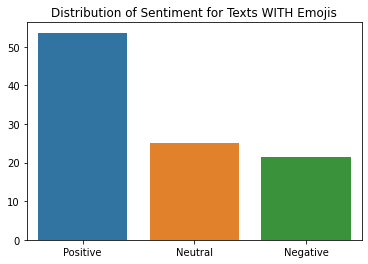

In [96]:
sns.barplot(x = emoji_sent.index, y = emoji_sent.values)
plt.title('Distribution of Sentiment for Texts WITH Emojis')
plt.show()

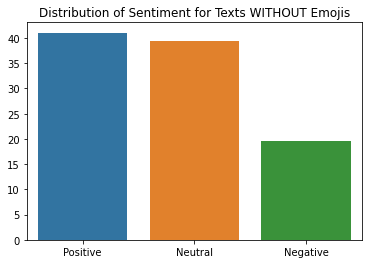

In [97]:
sns.barplot(x = nonemoji_sent.index, y = nonemoji_sent.values)
plt.title('Distribution of Sentiment for Texts WITHOUT Emojis')
plt.show()

It appears that tweets that do NOT have emojis have a much higher distribution of *Neutral* tweets, with most of that distribution increasing as a result of having a lower distribution of *positive* tweets.

While we saw the impact of how emojis can significantly increase the negative sentiment score of a tweet, it appears that removing the emojis may mostly make positive tweets more neutral.

I will try to remove all emojis, inspect the highest ranked scores again and see what the results look like before moving forward with vectorizing the text.  Research and assistance to pre-process emoji data was mostly found [HERE](https://medium.com/geekculture/text-preprocessing-how-to-handle-emoji-emoticon-641bbfa6e9e7)

### Removing Emoji's

The `re` library will help with some ReGex strings to identify emoji's and replace them with something appropriate.  Here we will use this to identify the unicode tags for each emoji and replace it with an empty string.

In [98]:
#Funtion to identify emoji and replace it with an empty string
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # Identifying emoticons
                           u"\U0001F300-\U0001F5FF" # Identifying symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # Identifying transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # Identifying flags from iOS
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string) #substitute the emoji tag with an empty string

In [99]:
# Testing with one of the top sentiment scores
# This one was the top negative score that had several fire emoji's
emoji_remove_test = mavs_sentiment_df.sort_values('Negative', ascending = False).reset_index().head(10)['Text'][0]

In [100]:
emoji_remove_test

'DALLAS MAVERICKS BASKETBALL 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥'

In [101]:
remove_emoji(emoji_remove_test)

'DALLAS MAVERICKS BASKETBALL '

In [102]:
emoji_removed = remove_emoji(emoji_remove_test)

In [103]:
# Sentiment score with Emoji
sid_obj.polarity_scores(emoji_remove_test)

{'neg': 0.935, 'neu': 0.065, 'pos': 0.0, 'compound': -0.9884}

In [104]:
# Sentiment score with Emoji 
sid_obj.polarity_scores(emoji_removed)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Unsurprising given what remained of the text, but this turned the text with the HIGHEST negative score into one that was completely neutral.  This is probably more accurate, but it would be good to see if some of the (more accurate) sentiment of the emoji remained.

I'll run this through the full dataframe and see what we get.

In [105]:
mavs_emoji_removed_df = mavs_df2.copy()

In [106]:
# Removing Emojis
for n in range(0, mavs_emoji_removed_df.shape[0]):
    no_emoji_tweet = mavs_emoji_removed_df['Text'][n]
    mavs_emoji_removed_df['Text'][n] = remove_emoji(no_emoji_tweet)

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/3555629443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mavs_emoji_removed_df['Text'][n] = remove_emoji(no_emoji_tweet)


In [107]:
# Rescoring Sentiment with VADER
mavs_emoji_removed_sentiment_df = score_sentiment(mavs_emoji_removed_df)

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1474832447.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'][n] = text
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1474832447.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Positive'][n] = scores['pos']
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/1474832447.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [108]:
# Checking out positive statements
mavs_emoji_removed_sentiment_df.sort_values('Positive', ascending = False).reset_index().head(10)['Text']

0                             FEARLESS  
1                               Agreed. 
2                              SPECIAL. 
3    @dallasmavs great win great defense
4        Wow, good luck @dallasmavs LOL 
5            Nice win! Love @dallasmavs 
6            @dallasmavs Yes yes Yes yes
7            @dallasmavs Yes yes Yes yes
8            @dallasmavs Yes yes Yes yes
9                GREAT WIN!! @dallasmavs
Name: Text, dtype: object

This looks like it is yielding much better results for the positive scores, as the top 10 positive are all very clearly positive.

In [109]:
mavs_emoji_removed_sentiment_df.sort_values('Negative', ascending = False).reset_index().head(10)['Text']

0                                Rejected  
1               @dallasmavs Suck Suck Suck!
2                 @dallasmavs WTF!?!?!? Smh
3             @dallasmavs Dirt dirty dirty 
4         Stop freaking Moody!  @dallasmavs
5                     Dead ass @dallasmavs 
6         @dallasmavs Embarrassing loss smh
7    @dallasmavs @Chime Fuck fuck fuck fuck
8                    Stupid ass @dallasmavs
9                @dallasmavs #TERRIBLE LOSS
Name: Text, dtype: object

This is also showing much better scores, as these are filled with clearly negative tweets, with many filled with expletives, and even implied explitives (ie. WTF).

In [110]:
mavs_emoji_removed_sentiment_df.sort_values('Neutral', ascending = False).reset_index().head(10)['Text']

0    Dallas Mavericks (27-20, fifth in the Western ...
1    Dallas Mavericks vs. Phoenix Suns: JaVale McGe...
2           @dallasmavs @Chime Next up, the Bkn Nets 🥲
3    Tim Hardaway Jr. - Dallas Mavericks29 PTS7 RBD...
4    Jalen Brunson - Dallas Mavericks15 PTS3 RBD8 A...
5    Dallas Mavericks CourtsideMen's Nike NBA Fleec...
6    Dwight Powell - Dallas Mavericks5 PTS4 RBD5 AS...
7    @RossMKE @kirkgoldsberry @Bucks @dallasmavs @M...
8    @dallasmavs @luka7doncic Only the highest IQs ...
9    #MFFL #dALLasIn #RallyTheValley #DallasMaveric...
Name: Text, dtype: object

Even these are showing more neutrality.  Many are have links for highlights (which should likely be removed for sentiment analysis) or giving stats/gambling lines, informational but neutral sentiment.

In [111]:
mavs_emoji_removed_sentiment_df.sort_values('Compound', ascending = False).reset_index().head(10)['Text']

0    @dallasmavs @Chime Let’s all laugh at Dallas M...
1    Is @stephenasmith still talking?@FirstTake The...
2    @dallasmavs @Chime Let’s all laugh at the warr...
3    @NBAonTNT @dallasmavs @ATLHawks @channingfrye ...
4    @dallasmavs @Chime LET'S ALL LAUGH AT THE LALL...
5    @dallasmavs MAVS WON THE TRADE!MAVS WON THE TR...
6    @ultralightbeam @dallasmavs @Chime 🤣🤣🤣🤣🤣 warri...
7    @dallasmavs @kporzee In nine minutes we scored...
8    A little late but wanted to send out birthday ...
9    @rs7united @life_cavs @1zagreus @ActorTonyRomo...
Name: Text, dtype: object

These are the compound scores that are the **MOST** positive.  It looks like there may be a few here that are 'sacastically' positive, or misinterpreted (I would consider laughing AT Dallas to be negative, even if 'laugh' is a positive connotation).  It also looks like not every emoji was captured, perhaps the list provided is not full comprehensive, although at least somewhat effective.

In [112]:
mavs_emoji_removed_sentiment_df.sort_values('Compound', ascending = True).reset_index().head(10)['Text']

0    @DwightPowell33  YOU FUCKIN SUCK BITCH YOU COU...
1    @dallasmavs @Suns @NBA FLOP FLOP FLOP FLOP FLO...
2    @redsoxfan20009 @dallasmavs WTF is this?  But ...
3    @utahjazz them folks up there in Utah don’t de...
4    Fuck Dallas, fuck a maverick, fuck mark cuban,...
5    @JeffMil276 @dallasmavs But I'll answer that f...
6    They have this at a bar in Dallas. You have to...
7    Dallas mavericks are a choke of a team Choked ...
8    Basketball tweet: It pains me to say this, but...
9    @Frog42 @Mavs_Win @dallasmavs @Chime Ofcause i...
Name: Text, dtype: object

In [113]:
mavs_emoji_removed_sentiment_df.sort_values('Compound', ascending = True).reset_index().head(10)['Text'][0]

'@DwightPowell33  YOU FUCKIN SUCK BITCH YOU COULDNT MAKE ATLEAST ONE FUCKIN FREE THROW??????? BOY IM FUCKIN PISSED SAD ASS. @dallasmavs  TRADE HIS STUPID SAD ASS!'

In [114]:
removeemoji_sent = mavs_emoji_removed_sentiment_df.loc[mavs_emoji_removed_sentiment_df.index.isin(emoji_index_list), 'Sentiment'].value_counts(normalize = True)*100

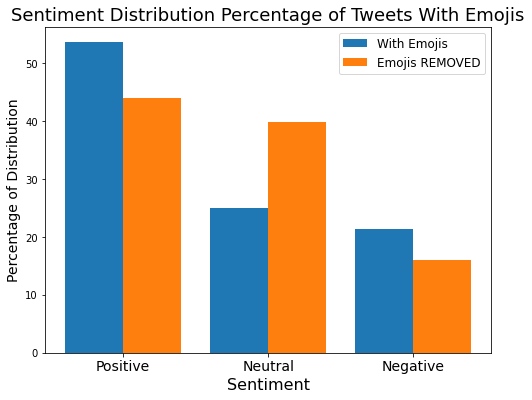

In [115]:
labels = emoji_sent.index
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize = (8, 6))
plt.bar(x-width/2, emoji_sent.values, width, label = 'With Emojis')
plt.bar(x+width/2, removeemoji_sent.values, width, label = 'Emojis REMOVED')
plt.title('Sentiment Distribution Percentage of Tweets With Emojis', fontsize = 18)
plt.xticks([0,1,2], labels, fontsize = 14)
plt.xlabel('Sentiment', fontsize = 16)
plt.ylabel('Percentage of Distribution', fontsize = 14)
plt.legend(loc = 'upper right', ncol = 1, labelspacing = 0.5, fontsize = 12)
plt.show()

As predicted, removing the emojis made those tweets significantly more *Neutral*, but that increase drew from BOTH positive and negative distributions.  That being said, it appeared that some emojis were overpowering the `Sentiment` scores in a way that was not capturing the true emotion of the tweet.  Therefore, simply removing the emojis should improve the validity of the sentiment scores with some risk that more tweets will be misclassified as 'neutral'.

<a id = 'secondaryeda'></a>

## 5. Secondary Exploratory Data Analysis - Emoji's Removed, Sentiment Scores Appended

In [116]:
emoji_removed_values = mavs_emoji_removed_sentiment_df['Sentiment'].value_counts(normalize = True)

In [117]:
with_emoji_values = mavs_sentiment_df['Sentiment'].value_counts(normalize = True)

In [118]:
sentiment_values = pd.DataFrame(columns = ['with_emojis', 'without_emojis'])
sentiment_values['with_emojis'] = with_emoji_values
sentiment_values['without_emojis'] = emoji_removed_values
sentiment_values

,with_emojis,without_emojis
Positive,0.431556,0.415239
Neutral,0.369213,0.394331
Negative,0.199231,0.190430


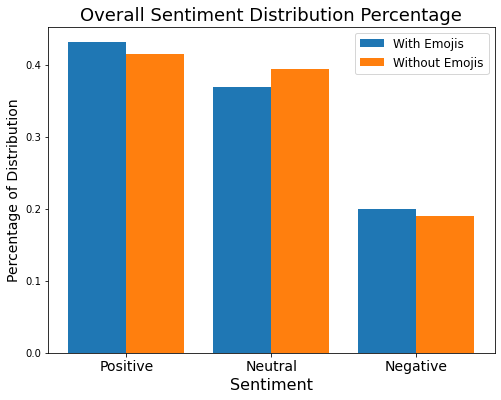

In [119]:
labels = sentiment_values.index
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize = (8, 6))
plt.bar(x-width/2, sentiment_values['with_emojis'], width, label = 'With Emojis')
plt.bar(x+width/2, sentiment_values['without_emojis'], width, label = 'Without Emojis')
plt.title('Overall Sentiment Distribution Percentage', fontsize = 18)
plt.xticks([0,1,2], labels, fontsize = 14)
plt.xlabel('Sentiment', fontsize = 16)
plt.ylabel('Percentage of Distribution', fontsize = 14)
plt.legend(loc = 'upper right', ncol = 1, labelspacing = 0.5, fontsize = 12)
plt.show()

Removing the emojis did have a significant effect on the proportions for each `Sentiment` category.  In general, the number of tweets that were neutral increased while the positive AND negative number of tweets decreased.  It would appear that removing the emojis had a significant effect on changing the overall categorization of the tweets.  Unfortunately the sentiment from the emojis themselves are not kept here, but as seen with the previous examples, this looks to be a more accurate representation of the sentiment of the tweets that we do have.

Considering I chose Vader for its ability to more accurately label negative sentiments, it is interesting to see that the negative category is by far the smallest of the 3 categories.

Therefore, I will do some additional Exploratory Data Analysis on the data that no longer has emojis on it, but does have sentiment scores.  This will hopefull provide some greater insight as we now prepare to understand how to predict on created target variable: `Sentiment`.

In [120]:
sentiment_df = mavs_emoji_removed_sentiment_df[['Positive', 'Neutral', 'Negative', 'Compound']].copy()

In [121]:
x, y = 'location', 'Sentiment'

location_sentiment = (mavs_emoji_removed_sentiment_df
                      .groupby(x)[y]
                      .value_counts(normalize=True)
                      .mul(100)
                      .rename('percent')
                      .reset_index())

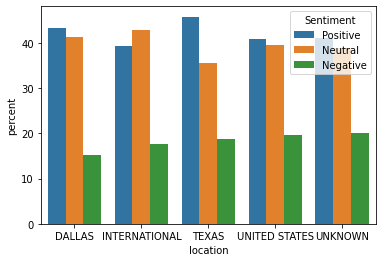

In [122]:
sns.barplot(x = 'location', y = 'percent', hue = 'Sentiment', data = location_sentiment)
plt.show()

There are subtle differences between `Sentiment` and `location`.  It appears that DALLAS has the least negative sentiment, whereas TEXAS has the most positive.  However, the general shape of these suggests that predicting sentiment on location may be difficult.

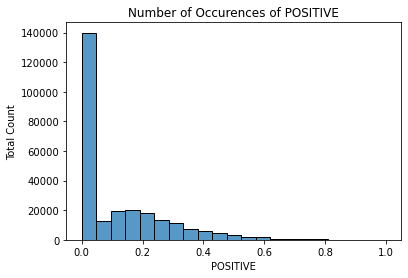

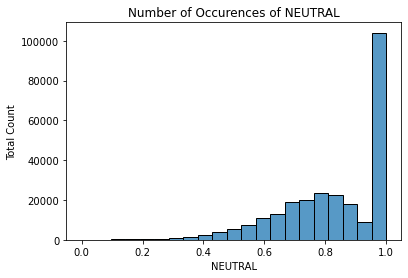

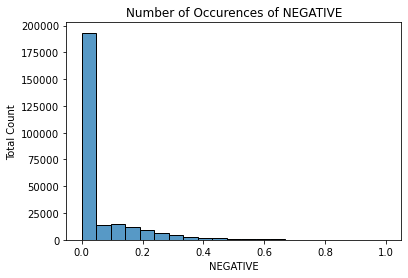

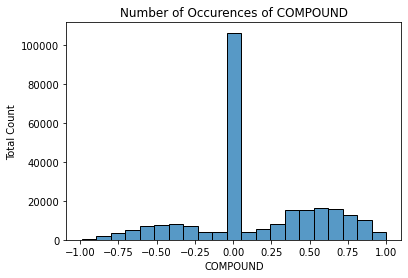

In [123]:
for col in sentiment_df.columns:
    plt.figure()
    sns.histplot(x = sentiment_df[col], data = sentiment_df, bins = 21)
    plt.title('Number of Occurences of '+col.upper())
    plt.xlabel(col.upper())
    plt.ylabel('Total Count')
    plt.show()

These histograms accurately portray what we've seen in the distribution of `Sentiment`.  Neutral scores require exactly 0 on the compound score, suggesting they would also have 0 on positive and negative scores.  Considering nearly 40% of the tweets are neutral, it is no surprise that there is a large distribution of scores representing neutral tweets.

These also show that there is a greater distribution of Positive scores than negative ones, which aligns with the fact that 40% of the tweets are classified as Positive and less than 20% are negative.

In [124]:
mavs_emoji_removed_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262916 entries, 0 to 262915
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype                     
---  ------                --------------   -----                     
 0   Datetime              262916 non-null  datetime64[ns, US/Central]
 1   Tweet Id              262916 non-null  int64                     
 2   Text                  262916 non-null  object                    
 3   Username              262916 non-null  object                    
 4   location              262916 non-null  object                    
 5   reply count           262916 non-null  int64                     
 6   retweet count         262916 non-null  int64                     
 7   like count            262916 non-null  int64                     
 8   Twitter Access Point  262916 non-null  object                    
 9   Follower Count        262916 non-null  int64                     
 10   Friends Count        262916 non

In [125]:
numeric_mavs_df2 = mavs_emoji_removed_sentiment_df.select_dtypes(['int64']).drop(columns = 'Tweet Id')

In [126]:
numeric_mavs_df2.columns

Index(['reply count', 'retweet count', 'like count', 'Follower Count',
       ' Friends Count'],
      dtype='object')

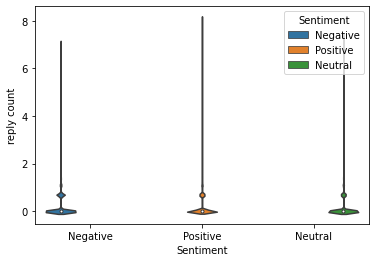

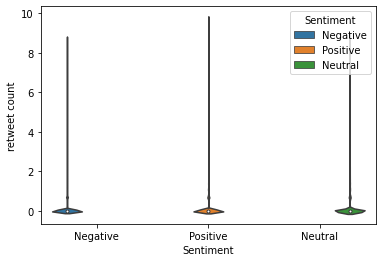

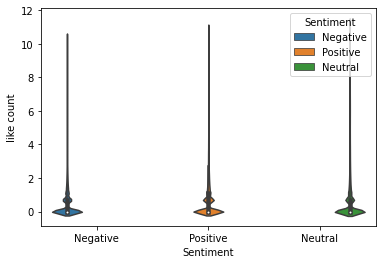

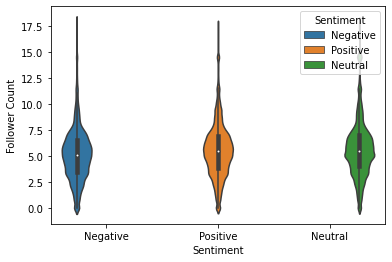

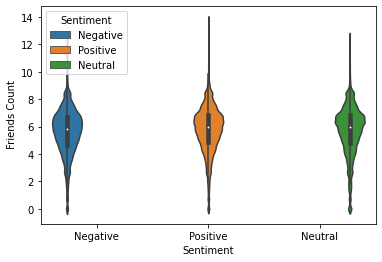

In [127]:
# Alternate view of distributions of numeric values
for col in numeric_mavs_df2.columns:
    sns.violinplot(x = 'Sentiment',
                y = np.log(numeric_mavs_df2[col]+1),
                hue = 'Sentiment',
                data = mavs_emoji_removed_sentiment_df)
    plt.show()

The distribution within each `Sentiment` value seems to be very similar across the numeric columns without much differentiation.

In [128]:
datetime_sentiment = mavs_emoji_removed_sentiment_df.groupby([mavs_emoji_removed_sentiment_df['Datetime'].dt.date]).mean()\
[['Positive','Neutral', 'Negative', 'Compound']]

In [129]:
datetime_sentiment_week = mavs_emoji_removed_sentiment_df.groupby([mavs_emoji_removed_sentiment_df['Datetime'].dt.week]).mean()\
[['Positive','Neutral', 'Negative', 'Compound']]

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_50677/3366074958.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  datetime_sentiment_week = mavs_emoji_removed_sentiment_df.groupby([mavs_emoji_removed_sentiment_df['Datetime'].dt.week]).mean()\


In [130]:
datetime_sentiment

,Positive,Neutral,Negative,Compound
Datetime,,,,
2021-09-30,0.108990,0.812691,0.078309,0.101752
2021-10-01,0.099719,0.855331,0.044937,0.100849
2021-10-02,0.119713,0.832618,0.047646,0.159853
2021-10-03,0.116638,0.841991,0.041381,0.146954
2021-10-04,0.165335,0.807475,0.027181,0.272603
...,...,...,...,...
2022-05-28,0.117404,0.846184,0.036414,0.184273
2022-05-29,0.104318,0.850102,0.045568,0.120302
2022-05-30,0.087892,0.859154,0.052910,0.100904


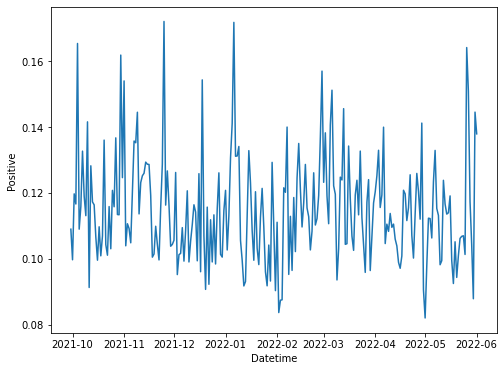

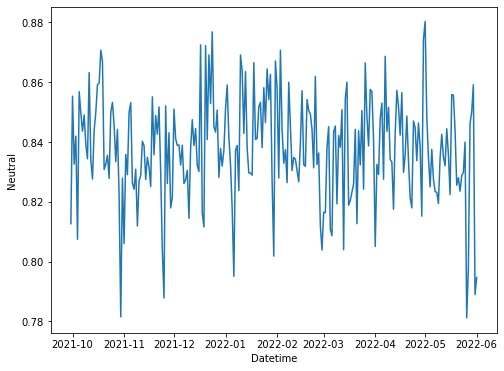

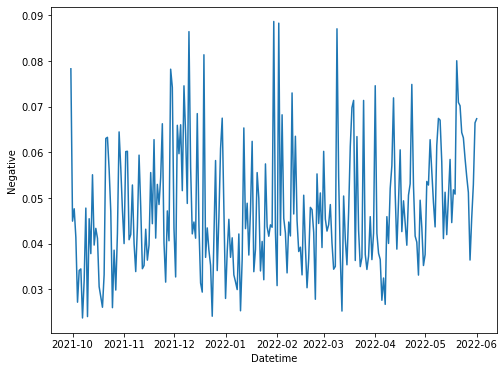

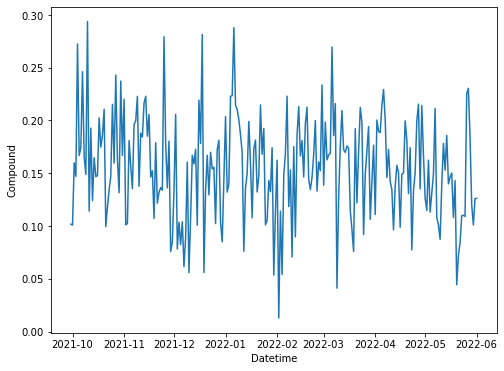

In [131]:
for col in datetime_sentiment.columns:
    plt.figure(figsize = (8, 6))
    sns.lineplot(x = datetime_sentiment.index,
                y = col,
                data = datetime_sentiment)
    plt.show()

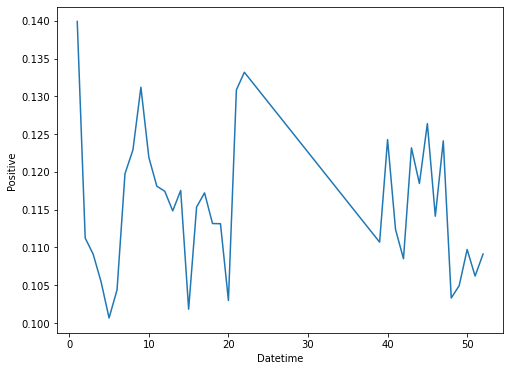

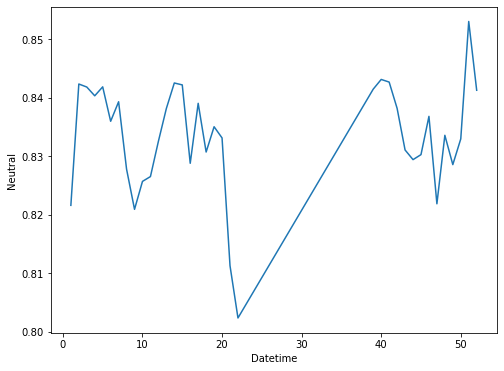

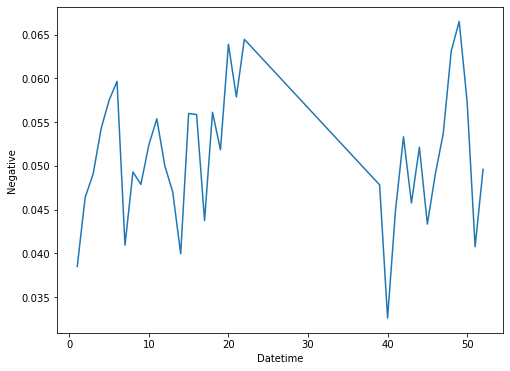

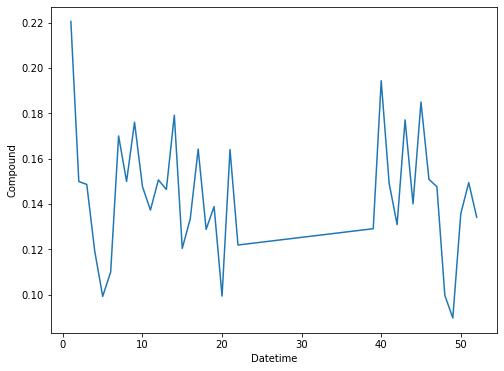

In [132]:
for col in datetime_sentiment.columns:
    plt.figure(figsize = (8, 6))
    sns.lineplot(x = datetime_sentiment_week.index,
                y = col,
                data = datetime_sentiment_week)
    plt.show()

Looking at the changes in the sentiment scores over the course of the season yields some interesting trends.  Considering the Dallas Mavericks made it to the conference finals in the 2022 playoffs, overall they had a very good season, with arguably one of the best young players in the league in Luka Doncic.

The most universally positive time of the year was the start of January, where the `Positive` and `Compound` score was the highest and both the `Negative` and `Neutral` scores were low.  On January 5th, the Mavericks defeated the future champion Golden State Warriors, which may have resulted in a flurry of positive tweets towards the Dallas Mavericks.

The end of their season in June had a significant drop in the `Neutral` scores, with both `Positive` and `Negative` scores being very high.  It would seem that during the playoffs tweets were more distinctively positive (for the Mavericks) or negative (against the Mavericks, perhaps from opposing teams fans).  

<a id = 'export'></a>

## 6. Export Cleaned Data + Conclusion

This is what was accomplished in this notebook:

1. Kept only English language tweets.
2. Binned `location` into 5 categories: Unknown, International, United States, Texas, Dallas
3. Added Sentiment Scores using Vader, including establishing the eventual target variable: `location`
4. Removed emojis from Tweets
5. Exploratory Data Analysis across all features and their relation to the target variable.

With this, I will export the final dataframe as a pickle to be transferred into a new notebook in order to start vectorizing the text of the twitter data.

In [133]:
with open('mavs_sentiment.pickle', 'wb') as f:
    pickle.dump(mavs_emoji_removed_sentiment_df, f)